# **1- Download the data**

In [2]:
# Get data
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the dowloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-06-21 16:24:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.8MB/s    in 8.2s    

2023-06-21 16:24:40 (19.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder
import os

# Walk through the data
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

# **2- Preprocessing data**

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

print("Training images:")
train_data_10_percentages = train_datagen.flow_from_directory(train_dir,
                                                              target_size=IMAGE_SHAPE,
                                                              batch_size=BATCH_SIZE,
                                                              class_mode="categorical")

print("Testing images:")
test_data_10_percentage = test_datagen.flow_from_directory(test_dir,
                                                           target_size=IMAGE_SHAPE,
                                                           batch_size=BATCH_SIZE,
                                                           class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## **2-1- Setting up callbacks (things to run whilst our model trains)**

In [5]:
import tensorflow as tf
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + "experiment_name" + "/" + datetime.datetime.now().strftime("%Y/%m/%d, %H:%M:%S")
  tensorboard_callnack = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving tensorboard log files to: {log_dir}")
  return tensorboard_callnack

# **3- Creating models using TensorFlow Hub**

##**3-0- Define a `create-model` Function**

In [6]:
# Import dependencies
import tensorflow_hub as hub

# Create a function for creating a model
def create_model(model_url, num_classes=10):
  """
  Take a tensorflow Hub url and create a sequential model with it.

  Args:
  model_url:  A TensorFlow Hub feature extraction URL.
  num_classes: Number of output neurons in output layer,

  Returns:
  An uncompiled Keras Sequential model with model_url as feature
  extractor layer and Dense output layer with num_classes outputs.
  """

  # Download the pretrained model and save it as a keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                      trainable=False,
                                      input_shape=IMAGE_SHAPE+(3,),
                                      name="feature_extraction_layer")
  # Create our own model
  model = tf.keras.Sequential([
      feature_extraction_layer, # Use it as a base model
      tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer") # Create output layer
  ])
  return model

## **3-1- Create the ResNet model (resnet_v2_50)**
> https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5



In [7]:
# Find and download the model
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# Create the ResNet model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percentages.num_classes)

# Compile the model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

#Fit our resnet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percentages,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percentages),
                                  validation_data=test_data_10_percentage,
                                  validation_steps=len(test_data_10_percentage),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving tensorboard log files to: tensorflow_hub/experiment_name/2023/06/21, 16:24:56
Epoch 1/5
24/24 [==============================] - 33s 827ms/step - loss: 1.8991 - accuracy: 0.3613 - val_loss: 1.2378 - val_accuracy: 0.6132
Epoch 2/5
24/24 [==============================] - 18s 756ms/step - loss: 0.8794 - accuracy: 0.7360 - val_loss: 0.8852 - val_accuracy: 0.7132
Epoch 3/5
24/24 [==============================] - 19s 810ms/step - loss: 0.5985 - accuracy: 0.8373 - val_loss: 0.7725 - val_accuracy: 0.7576
Epoch 4/5
24/24 [==============================] - 20s 873ms/step - loss: 0.4548 - accuracy: 0.8813 - val_loss: 0.7209 - val_accuracy: 0.7680
Epoch 5/5
24/24 [==============================] - 18s 787ms/step - loss: 0.3612 - accuracy: 0.9187 - val_loss: 0.6947 - val_accuracy: 0.7776


## **3-2- Create the EfficientNet model**

In [8]:
# Find and download the model
efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

# Create the ResNet model
efficientnet_model = create_model(model_url=efficientnet_url, num_classes=train_data_10_percentages.num_classes)

# Compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

#Fit our resnet model to the data (10 percent of 10 classes)
efficientnet_history = efficientnet_model.fit(train_data_10_percentages,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percentages),
                                              validation_data=test_data_10_percentage,
                                              validation_steps=len(test_data_10_percentage),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetB0V1")])

Saving tensorboard log files to: tensorflow_hub/experiment_name/2023/06/21, 16:26:53
Epoch 1/5
24/24 [==============================] - 26s 945ms/step - loss: 1.8087 - accuracy: 0.4893 - val_loss: 1.2997 - val_accuracy: 0.7132
Epoch 2/5
24/24 [==============================] - 20s 863ms/step - loss: 1.0449 - accuracy: 0.7787 - val_loss: 0.8705 - val_accuracy: 0.8116
Epoch 3/5
24/24 [==============================] - 18s 783ms/step - loss: 0.7412 - accuracy: 0.8480 - val_loss: 0.6996 - val_accuracy: 0.8416
Epoch 4/5
24/24 [==============================] - 19s 815ms/step - loss: 0.5973 - accuracy: 0.8747 - val_loss: 0.6143 - val_accuracy: 0.8500
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.5013 - accuracy: 0.8987 - val_loss: 0.5602 - val_accuracy: 0.8596


## **3-3- Create the MobileNet model**
> https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5

In [23]:
# Find and download the model
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

# Create the ResNet model
mobilenet_model = create_model(model_url=mobilenet_url, num_classes=train_data_10_percentages.num_classes)

# Compile the model
mobilenet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

#Fit our resnet model to the data (10 percent of 10 classes)
mobilenet_history = mobilenet_model.fit(train_data_10_percentages,
                                        epochs=10,
                                        steps_per_epoch=len(train_data_10_percentages),
                                        validation_data=test_data_10_percentage,
                                        validation_steps=len(test_data_10_percentage),
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                               experiment_name="mobilenetV2")])


Saving tensorboard log files to: tensorflow_hub/experiment_name/2023/06/21, 16:42:42
Epoch 1/10
24/24 [==============================] - 29s 1s/step - loss: 1.9396 - accuracy: 0.3427 - val_loss: 1.3199 - val_accuracy: 0.6020
Epoch 2/10
24/24 [==============================] - 19s 830ms/step - loss: 1.0205 - accuracy: 0.7067 - val_loss: 0.8929 - val_accuracy: 0.7452
Epoch 3/10
24/24 [==============================] - 20s 839ms/step - loss: 0.7215 - accuracy: 0.7933 - val_loss: 0.7447 - val_accuracy: 0.7812
Epoch 4/10
24/24 [==============================] - 16s 708ms/step - loss: 0.5772 - accuracy: 0.8413 - val_loss: 0.6768 - val_accuracy: 0.7888
Epoch 5/10
24/24 [==============================] - 24s 1s/step - loss: 0.4835 - accuracy: 0.8840 - val_loss: 0.6389 - val_accuracy: 0.7996
Epoch 6/10
24/24 [==============================] - 17s 748ms/step - loss: 0.4060 - accuracy: 0.9133 - val_loss: 0.6521 - val_accuracy: 0.7824
Epoch 7/10
24/24 [==============================] - 16s 704ms/s

# **4- Evaluate the model**

## **4-0- Define plot curves function**

In [14]:
# Define `plot-loss-curve` function
import matplotlib.pyplot as plt

def plot_loss_curve(history):
  """
  Returing a seperate loss curve for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot the loss curve
  plt.plot(epochs, loss, label="Loss")
  plt.plot(epochs, val_loss, label="Validaton loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy curve
  plt.figure()
  plt.plot(epochs, accuracy, label="Accuracy")
  plt.plot(epochs, val_accuracy, label="validation accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

## **4-1- Evaluate the ResNet model**

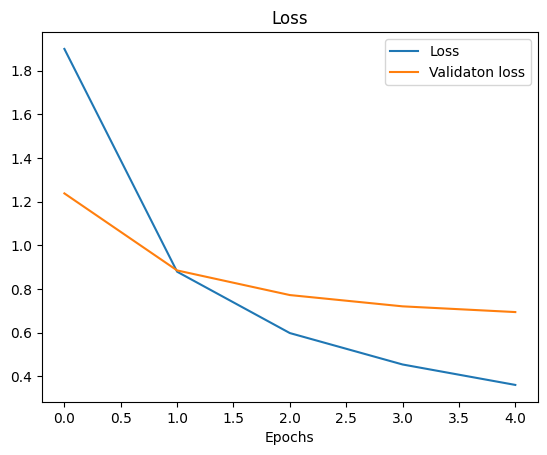

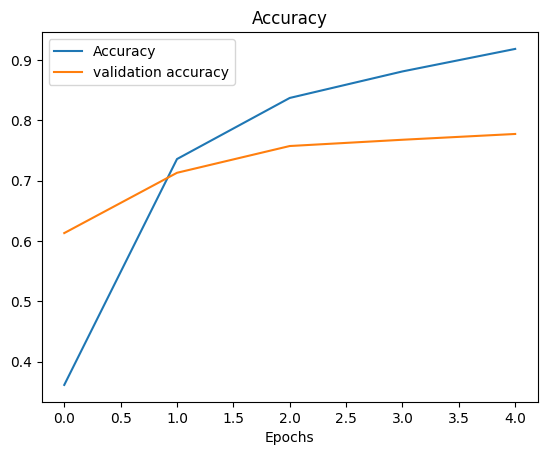

In [15]:
plot_loss_curve(resnet_history)

## **4-2- Evaluate the EfficientNet model**

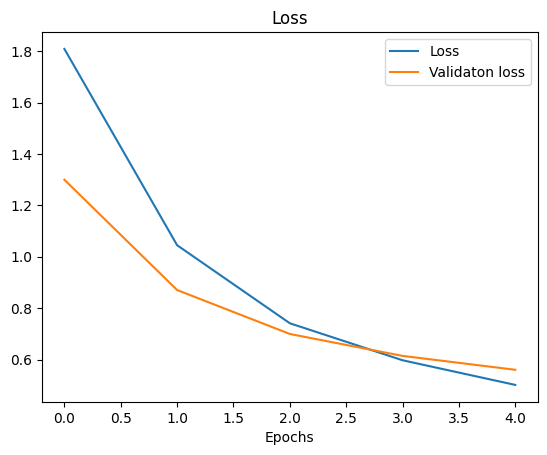

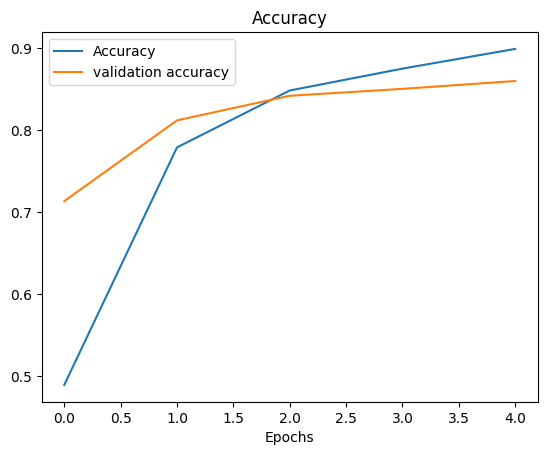

In [16]:
plot_loss_curve(efficientnet_history)

## **4-3- Evaluate the MobileNet model**

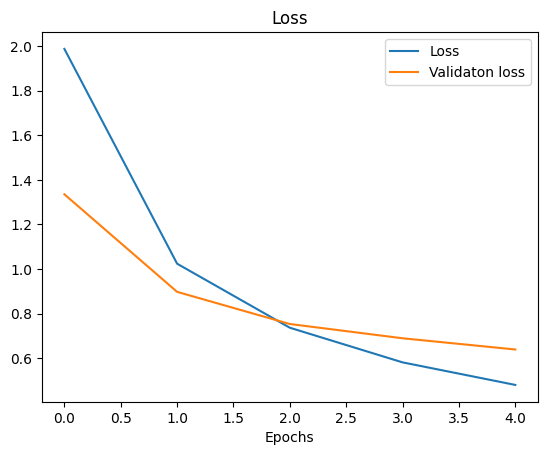

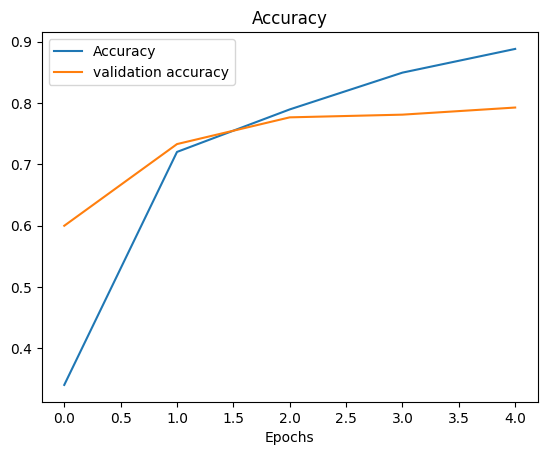

In [17]:
plot_loss_curve(mobilenet_history)

In [19]:
mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [22]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________
